In [6]:
include("PID.jl");

using DelimitedFiles
using Random,Distributions,CausalityTools, DelimitedFiles


In [7]:
ddir = "DATA/"

allfiles = readdir(ddir)

#allfiles = readdir()

#filesR = [i for i in allfiles if occursin(".csv", i)&occursin("Sim_ThresVar_", i)]

filesR = [i for i in allfiles if occursin(".csv", i)&occursin("pair_PotentialMonit_Both_200000", i)]

#filesR = [i for i in allfiles if occursin(".csv", i)&occursin("Potential_values_", i)]


1-element Vector{String}:
 "Simulation_pair_PotentialMonit_" ⋯ 54 bytes ⋯ "oise_400_avgnumspikes_575.0.csv"

In [8]:

ni = 1

filesR[ni]


"Simulation_pair_PotentialMonit_Both_200000_Cell_Pyr_p1__timebin_1_numinputs_5002_ISInoise_400_avgnumspikes_575.0.csv"

In [9]:
ddirD = ddir*split(filesR[ni],".c")[1]
#ddirD = ddir*split(filesR[ni],".c")[1]*"_Codebinning"
#ddirD = ddir*split(filesR[ni],".c")[1]*"_Continous"

isdir(ddirD) || mkdir(ddirD)


true

In [10]:

X = readdlm(ddir*filesR[ni],',',Int8,skipstart=1);

#V = readdlm(ddir*filesR[ni],',',Float32,skipstart=1);

#X = readdlm(filesR[ni],',',Int8,skipstart=1);


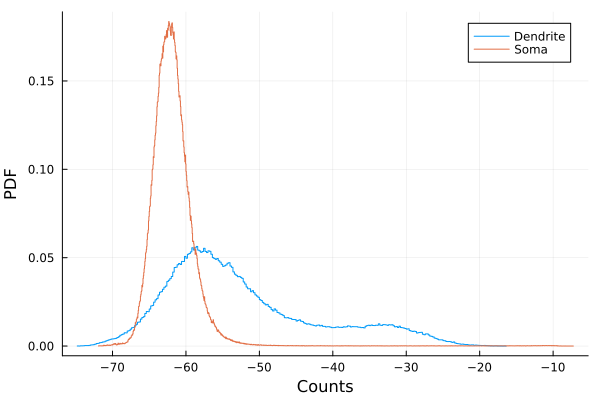

"/home/gustavo/Documents/LASCON/Project/synergisticDendrites/histogram_pot.png"

In [43]:
histogram(V[:,50],label="Dendrite",normalize=:pdf)
histogram!(V[:,1],label="Soma",normalize=:pdf)

plot!(xlabel="Counts")
plot!(ylabel="PDF")

display(plot!())

savefig("histogram_pot.png")


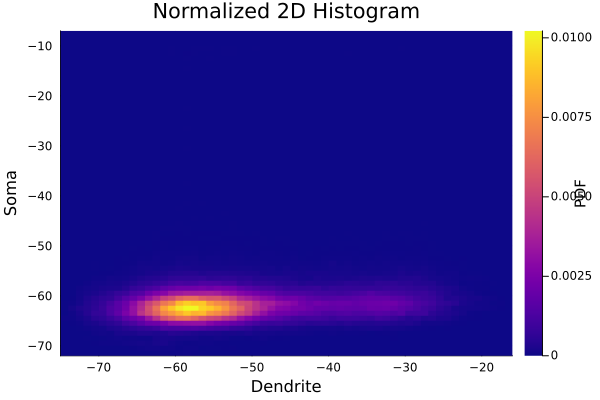

"/home/gustavo/Documents/LASCON/Project/synergisticDendrites/histogram2D_pot.png"

In [93]:

histogram2d(V[:,50], V[:,1], bins=(100, 100), show_empty_bins=true,normalize=:pdf, color=:plasma,cbar_title="PDF")

title!("Normalized 2D Histogram")

xlabel!("Dendrite")
ylabel!("Soma")

display(plot!())

savefig("histogram2D_pot.png")


In [96]:
dt = 0.125

Tau_c = Int.(collect(Int.(round.(LinRange(1,20,20),digits=0)))./dt);



4-element Vector{Int64}:
   8
  48
  88
 128

In [97]:
i = 1
j = 50

tt = Int.(round.(LinRange(100000,1600000,8)))

miG = []
mi = []

for ti in tt
    
    Vs = V[end-ti:end,:];

    miGT = []
    miT = []
    
    for t in Tau_c[1:5:end]
        
        append!(miT,mutualinfo(MIShannon(base = ℯ),Kraskov(k = 10),Dataset(Vs[1+t:end,1]),Dataset(Vs[1:end-t,[i+1,j+1]])))
        append!(miGT,mutualinfo(MIShannon(base = ℯ),GaussianMI(),Dataset(Vs[1+t:end,1]),Dataset(Vs[1:end-t,[i+1,j+1]])))
    
    end

    append!(mi,miT)
    append!(miG,miGT)

end


In [143]:

miT = reshape(mi,(4,8))
miGT = reshape(miG,(4,8))

Tau_c[1:5:end]*dt

4-element Vector{Float64}:
  1.0
  6.0
 11.0
 16.0

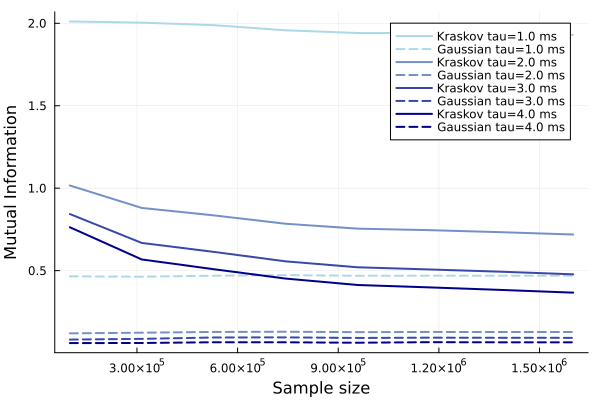

"/home/gustavo/Documents/LASCON/Project/synergisticDendrites/Mutual_information.png"

In [230]:
using Plots

plot(xlabel="Sample size")
plot!(ylabel="Mutual Information")

cc = palette(:blues, 4)

for i in 1:length(Tau_c[1:5:end])

    if i == 1
        plot!(tt,miT[i,:],label="Kraskov tau=$(Tau_c[i]*dt) ms",linewidth=2,color = cc[i])
        plot!(tt,miGT[i,:],label="Gaussian tau=$(Tau_c[i]*dt) ms",linestyle=:dash,linewidth=2,color = cc[i])
    else
        plot!(tt,miT[i,:],label="Kraskov tau=$(Tau_c[i]*dt) ms",linewidth=2,color = cc[i])
        plot!(tt,miGT[i,:],linestyle=:dash,label="Gaussian tau=$(Tau_c[i]*dt) ms",linewidth=2,color = cc[i])
        
    end
    
end

display(plot!())

savefig("Mutual_information.png")


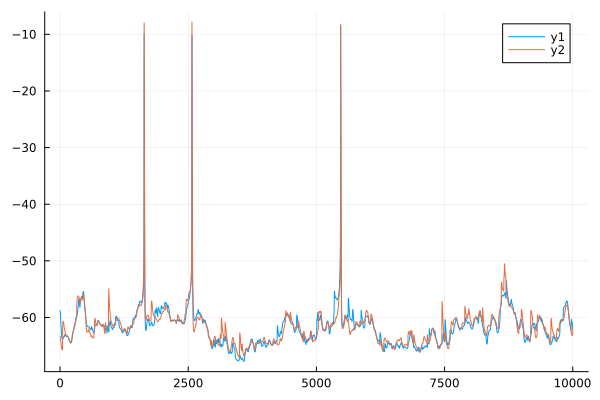

In [243]:

plot(V[end-10000:end,1])

plot!(V[end-10000:end,3])


In [69]:
i = 1
j = 50
t = 20

tt = Int.(round.(LinRange(100000,1600000,8)))

mi = []

for ti in tt
    
    Vs = V[end-ti:end,:];
    
    append!(mi,mutualinfo(MIShannon(base = ℯ),Kraskov(k = 10),Dataset(Vs[1+Tau_c[t]:end,1]),Dataset(Vs[1:end-Tau_c[t],[i+1,j+1]])))
    
end


([100000, 314286, 528571, 742857, 957143, 1171429, 1385714, 1600000], Any[0.7407960663246822, 0.5231965611155687, 0.4585347243353759, 0.40378263178306373, 0.36345458662180263, 0.3487617144611921, 0.33172948646862643, 0.3149699881779222])

In [15]:

function Timebining(X::Matrix{Int8},nt::Int32)
    
    T = size(X)[1]

    N = size(X)[2]

    TW = Int(floor(T/nt))

    xx = zeros(Int8,TW,N)

    for i in 1:TW

        xx[i,:] = 1 .*(sum(X[((i-1)*nt+1):i*nt,:],dims=1).>0)

    end
    
    return xx
end

function CodeBinning(X,Codesize,k)

    xx = Timebining(X,Int32(Timebin[k]))[1+end-Codesize*5000:end,:]

    base = [2^i for i in 0:(Codesize-1)]

    Tt = size(xx)[1]
    Nn = size(xx)[2]

    xxp = zeros(Int16,Int(Tt/Codesize),Nn)

    for a in 1:Int(Tt/Codesize)-1

        xxp[a,:] = reduce(+,xx[1+(a-1)*Codesize:a*Codesize,:].*base,dims=1)

    end

    return xxp
end

function IMf_c(x,y)

    return mutualinfo(MIShannon(base = ℯ),Kraskov(k = 5),Dataset(x), Dataset(y))

end

function PID_c(T,X)

    RR = minimum([IMf_c(T,X[:,1]),IMf_c(T,X[:,2])])
    
    ru1 = IMf_c(X[:,1],T)
    ru2 = IMf_c(X[:,2],T)
        
    U1 = ru1 - RR

    U2 = ru2 - RR
    
    Syn = IMf_c(X,T) - ru1 - ru2 + RR
        
    return [RR,U1,U2,Syn]
end

PID_c (generic function with 1 method)

In [13]:
est = Kraskov(k = 10, base = ℯ)

Vs = V[:,:];

hT = ComplexityMeasures.entropy(est,Vs[:,1])


2.925680216971248

In [ ]:
T = size(Vs)[1]

N = size(Vs)[2]-1

#Tau = [1,2,4,8,16]

#Timebin = [1,5,10,15,20]

hT = ComplexityMeasures.entropy(est,Vs[:,1])

io = open(ddirD*"/Target_entropy_timebin.txt","w")

writedlm(io,hT,",")

close(io)

Threads.@threads :static for t=1:20

    Res = zeros(Float32,N,N,4)

    for i in 1:N-1

        for j in i+1:N

            Res[i,j,:] = PID_c(Vs[1+Tau_c[t]:end,1],Vs[1:end-Tau_c[t],[i+1,j+1]])
            Res[j,i,:] = Res[i,j,[1,3,2,4]]

        end

    end

    PIDlab = ["Red","Un1","Un2","Syn"]

    ii = [1,2,3,4]

    for i in 1:length(PIDlab)

        io = open(ddirD*"/PID_"*PIDlab[i]*"_tau_$(Tau_c[tk]).txt","w")

        writedlm(io,Res[:,:,ii[i]]./hT,",")

        close(io)

    end

end


In [16]:

Tau = collect(Int.(round.(LinRange(1,40,40),digits=0)))

Timebin = collect(Int.(round.(LinRange(1,40,40),digits=0)));


In [18]:
T = size(X)[1]

N = size(X)[2]-1

#Tau = [1,2,4,8,16]

#Timebin = [1,5,10,15,20]

Threads.@threads :static for k=1:40

    xx = Timebining(X,Int32(Timebin[k]))[1+end-5000:end,:]

    psT = probabilities(Dataset(xx[:,1]));
    
    hT = ComplexityMeasures.entropy(Shannon(; base = 2),psT)

    io = open(ddirD*"/Target_entropy_timebin_$(Timebin[k]).txt","w")

    writedlm(io,hT,",")

    close(io)

    Res = zeros(Float32,N,N,4,length(Tau))

    for i in 1:N-1

        for j in i+1:N

            for t in 1:length(Tau)

                Res[i,j,:,t] = PID(xx[1+Tau[t]:end,1],xx[1:end-Tau[t],[i+1,j+1]])
                Res[j,i,:,t] = Res[i,j,[1,3,2,4],t]

            end

        end

    end

    PIDlab = ["Red","Un1","Un2","Syn"]

    ii = [1,2,3,4]

    for tk in 1:length(Tau)

        for i in 1:length(PIDlab)

            io = open(ddirD*"/PID_"*PIDlab[i]*"_tau_$(Tau[tk])_timebin_$(Timebin[k]).txt","w")

            writedlm(io,Res[:,:,ii[i],tk]./hT,",")

            close(io)

        end

    end

end


In [59]:
Codesize = 1

for ni in 1:length(filesR)

    ddirD = ddir*split(filesR[ni],".c")[1]*"_Codebinning"

    isdir(ddirD) || mkdir(ddirD)

    X = readdlm(ddir*filesR[ni],',',Int8,skipstart=1);

    N = size(X)[2]-1

    Threads.@threads :static for k=1:40
        
        Res = zeros(Float32,N,N,4,length(Tau))

        xx = CodeBinning(X,Codesize,k)#Timebining(X,Int32(Timebin[k]))[1+end-5000:end,:]
        
        #T = size(xx)[1]

        #Tau = [1,2,4,8,16]

        #Timebin = [1,5,10,15,20]

        for i in 1:N-1

            for j in i+1:N

                for t in 1:length(Tau)

                    Res[i,j,:,t] = PID(xx[1+Tau[t]:end,1],xx[1:end-Tau[t],[i+1,j+1]])
                    Res[j,i,:,t] = Res[i,j,[1,3,2,4],t]

                end

            end

        end

        PIDlab = ["Red","Un","Syn"]

        ii = [1,2,4]

        for tk in 1:length(Tau)

            for i in 1:length(PIDlab)

                io = open(ddirD*"/PID_"*PIDlab[i]*"_tau_$(Tau[tk])_timebin_$(Timebin[k]).txt","w")

                writedlm(io,Res[:,:,ii[i],tk],",")

                close(io)

            end

        end

    end

end


In [9]:
40*10000

400000

In [130]:

t = 1
k = 30

i = 3
j = 5

Nmax = Int(floor(Int(floor(size(X)[1]/Timebin[k])) / 200))-1

N = Int.(round.(LinRange(200,Nmax*200,Nmax)))

MI = zeros(Float32,length(N),4)

for ni in 1:length(N)
    
    nn = N[ni]
    
    if k!=1
        xx = Timebining(X[:,[1,i+1,j+1]],Int32(Timebin[k]))[end-nn:end,:]
    else
        xx = X[end-nn:end,[1,i+1,j+1]]
    end
    
    MI[ni,:] = PID(xx[1+Tau[t]:end,1],xx[1:end-Tau[t],2:end])
    
end


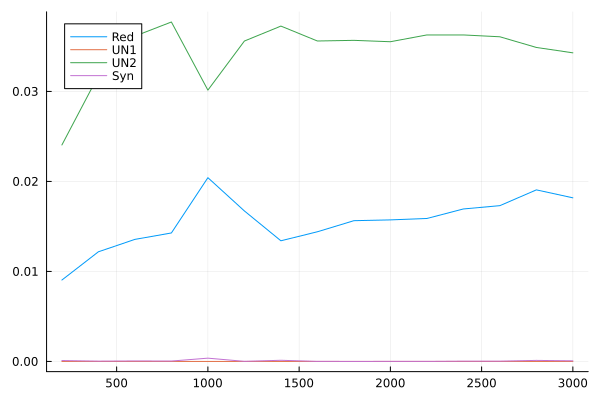

In [131]:
using Plots

plot(N,MI[:,1],label="Red")

plot!(N,MI[:,2],label="UN1")

plot!(N,MI[:,3],label="UN2")

plot!(N,MI[:,4],label="Syn")
